#**유통 판매량 예측 및 재고 최적화**
## **단계1 : 데이터 탐색 및 가설 도출**

# **0.미션**

* 예측해야 할 핵심상품 역할 분담
    * 핵심상품 별로, 데이터 탐색, 가설수립, 데이터셋 구성
    * 1인당 1~2개 정도를 분담하여 개별 과제 수행
    * 팀 미팅을 통해 진행 사항 공유 및 취합

* 데이터 탐색 및 가설 도출
    * 주어진 데이터에 대해 대상 매장, 대상 상품의 그래프 그리고 시계열 패턴을 찾기
    * 찾은 패턴을 기반으로 가설 도출

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
path = '/content/drive/MyDrive/KTaivle/6차미니프로젝트/'

### **(2) 라이브러리 설치 및 불러오기**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### **(3) 데이터 불러오기**

#### 1) 데이터로딩

In [171]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

#### 2) 기본 정보 조회

In [13]:
oil_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       825 non-null    datetime64[ns]
 1   WTI_Price  795 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.0 KB


In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57558 entries, 0 to 57557
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           57558 non-null  datetime64[ns]
 1   Store_ID       57558 non-null  int64         
 2   CustomerCount  57558 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.3 MB


In [15]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934275 entries, 0 to 934274
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        934275 non-null  datetime64[ns]
 1   Store_ID    934275 non-null  int64         
 2   Qty         934275 non-null  float64       
 3   Product_ID  934275 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 28.5 MB


In [16]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Product_ID    16 non-null     int64 
 1   Product_Code  16 non-null     object
 2   SubCategory   16 non-null     object
 3   Category      16 non-null     object
 4   LeadTime      16 non-null     int64 
 5   Price         16 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 896.0+ bytes


In [17]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Store_ID    54 non-null     int64 
 1   City        54 non-null     object
 2   State       54 non-null     object
 3   Store_Type  54 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.8+ KB


# **2.데이터 탐색**

* 시계열 패턴을 찾아보기 위한 그래프를 그려 봅시다.

## **(1) 시계열 패턴 찾아보기1**

* 다음 항목은 패턴을 찾기 위한 예제 문항 입니다. 참조하여 시계열 패턴을 찾아 봅시다.
    * 대상 매장(44), 대상 상품(3,12,42)의 판매량 추이
    * 대상 상품의 동일 카테고리의 상품별 판매량 추이
    * 휘발류 가격과 상품 판매량 추이 비교
    * 방문 고객수와 상품 판매량 추이 비교
    * 그외...

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [77]:
merged_data = pd.merge(sales, products, on='Product_ID')

<h1>3번 상품</h1>

In [78]:
DB001 = merged_data[(merged_data['Store_ID'] == 44) & (merged_data['Product_Code'] == 'DB001')]

In [88]:
same_category_3 = merged_data[(merged_data['Store_ID'] == 44) & (merged_data['Category'] == 'Drink')]

In [90]:
same_category_3['SubCategory'].unique()

array(['Beverage', 'Wine'], dtype=object)

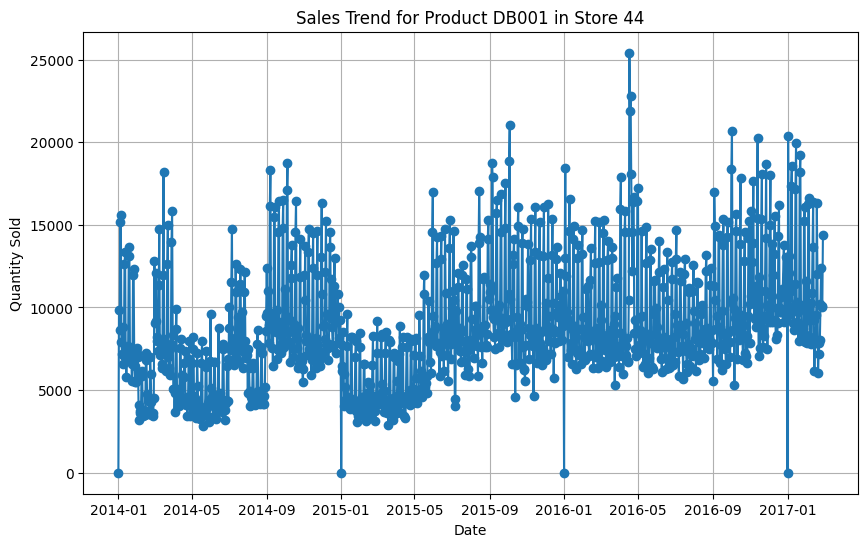

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(DB001['Date'], DB001['Qty'], marker='o', linestyle='-')
plt.title('Sales Trend for Product DB001 in Store 44')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()

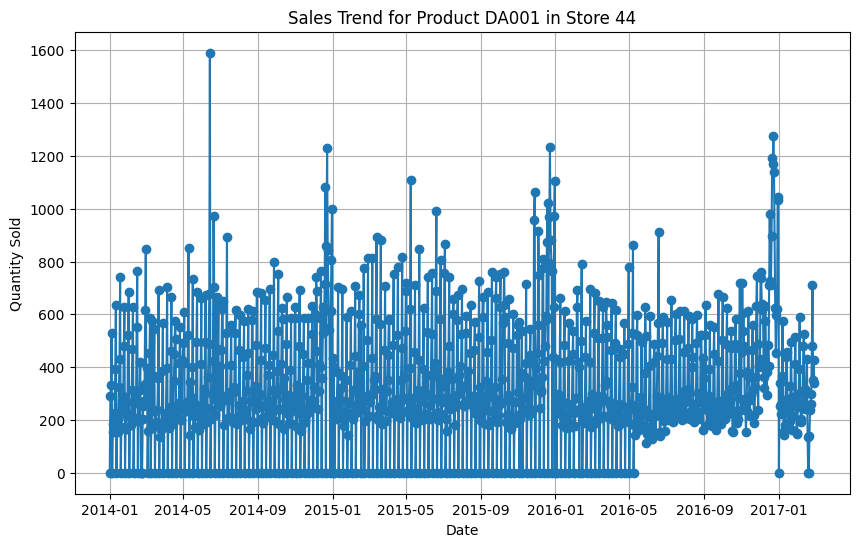

In [96]:
# DA001 Wine

DA001 = merged_data[(merged_data['Store_ID'] == 44) & (merged_data['Product_Code'] == 'DA001')]

plt.figure(figsize=(10, 6))
plt.plot(DA001['Date'], DA001['Qty'], marker='o', linestyle='-')
plt.title('Sales Trend for Product DA001 in Store 44')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()

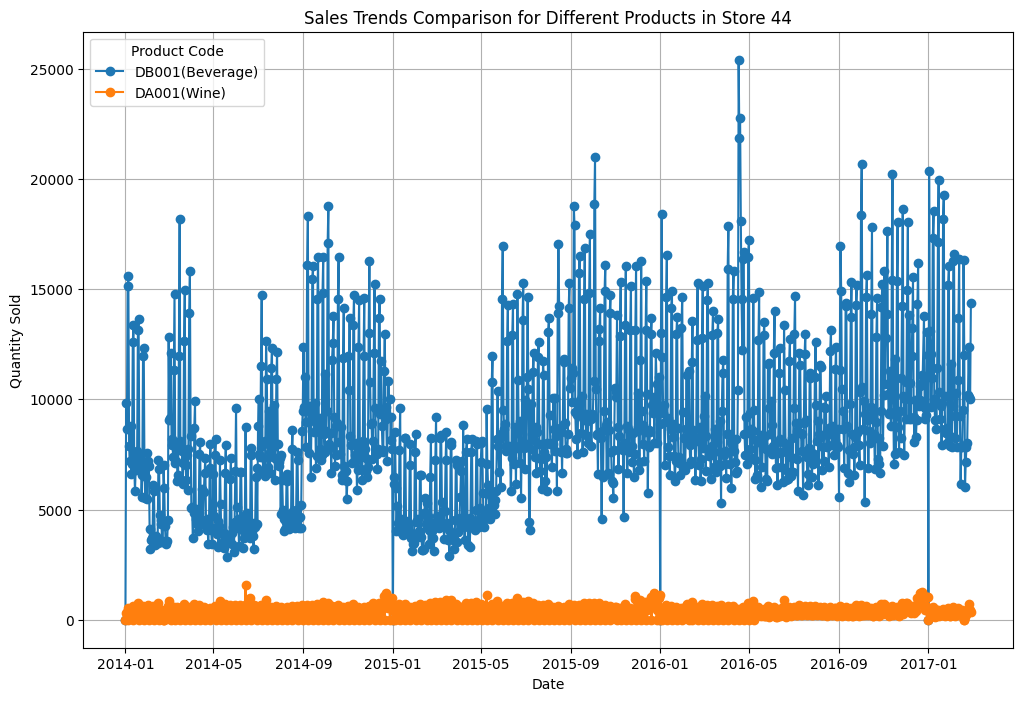

In [97]:
plt.figure(figsize=(12, 8))

# Beverage DB001
plt.plot(DB001['Date'], DB001['Qty'], marker='o', linestyle='-', label='DB001(Beverage)')

# Wine DA001
plt.plot(DA001['Date'], DA001['Qty'], marker='o', linestyle='-', label='DA001(Wine)')

plt.title('Sales Trends Comparison for Different Products in Store 44')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend(title='Product Code', loc='upper left')
plt.grid(True)
plt.show()


<h1>12번 상품</h1>

In [23]:
GA001 = merged_data[(merged_data['Store_ID'] == 44) & (merged_data['Product_Code'] == 'GA001')]

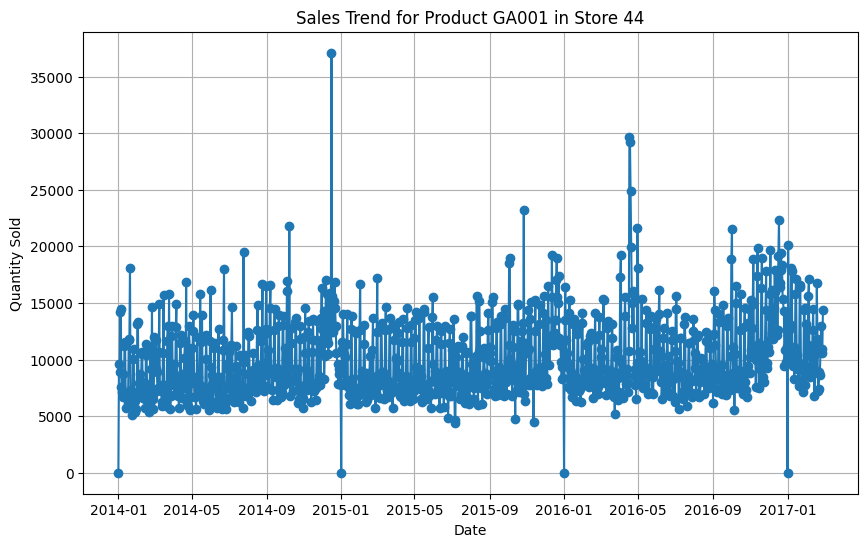

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(GA001['Date'], GA001['Qty'], marker='o', linestyle='-')
plt.title('Sales Trend for Product GA001 in Store 44')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()

### 2) 대상 상품의 동일 카테고리의 상품별 판매량 추이

In [83]:
same_category_12 = merged_data[(merged_data['Store_ID'] == 44) & (merged_data['Category'] == 'Food')]

In [84]:
same_category_12['SubCategory'].unique()

array(['BAKERY', 'Yogurt', 'Frozen', 'Milk', 'Prepared'], dtype=object)

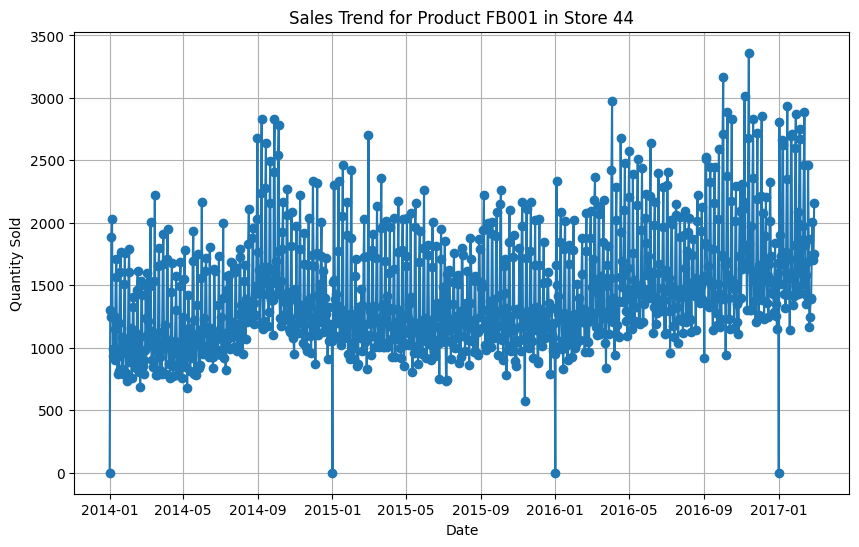

In [71]:
# BAKERY FB001

FB001 = merged_data[(merged_data['Store_ID'] == 44) & (merged_data['Product_Code'] == 'FB001')]

plt.figure(figsize=(10, 6))
plt.plot(FB001['Date'], FB001['Qty'], marker='o', linestyle='-')
plt.title('Sales Trend for Product FB001 in Store 44')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()

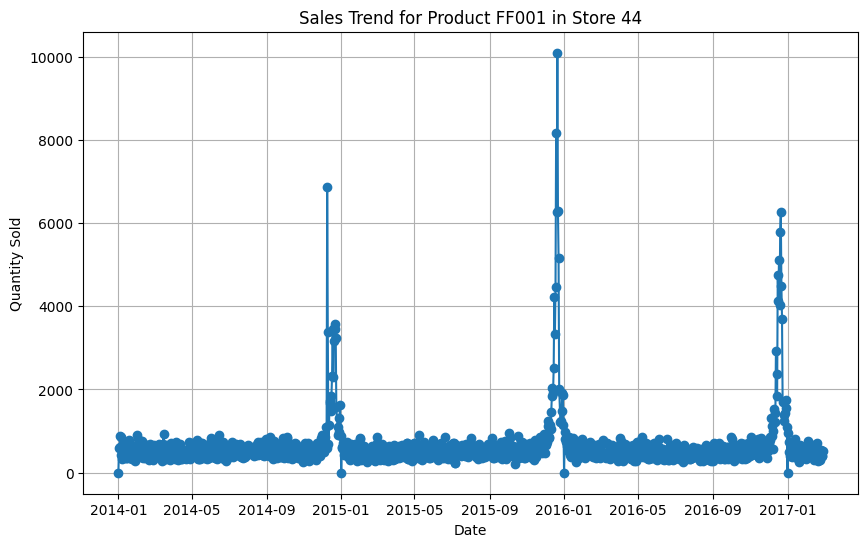

In [72]:
# Yogurt FF001

FF001 = merged_data[(merged_data['Store_ID'] == 44) & (merged_data['Product_Code'] == 'FF001')]

plt.figure(figsize=(10, 6))
plt.plot(FF001['Date'], FF001['Qty'], marker='o', linestyle='-')
plt.title('Sales Trend for Product FF001 in Store 44')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()

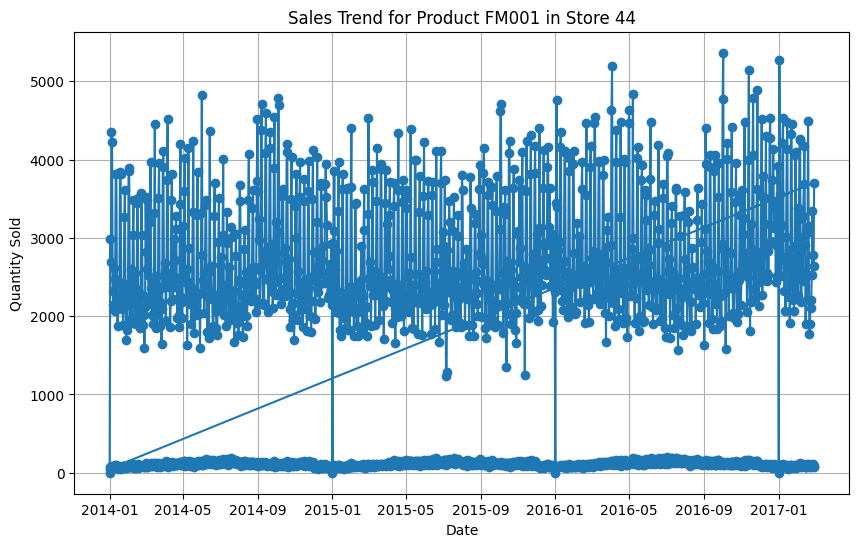

In [73]:
# Frozen FM001

FM001 = merged_data[(merged_data['Store_ID'] == 44) & (merged_data['Product_Code'] == 'FM001')]

plt.figure(figsize=(10, 6))
plt.plot(FM001['Date'], FM001['Qty'], marker='o', linestyle='-')
plt.title('Sales Trend for Product FM001 in Store 44')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()

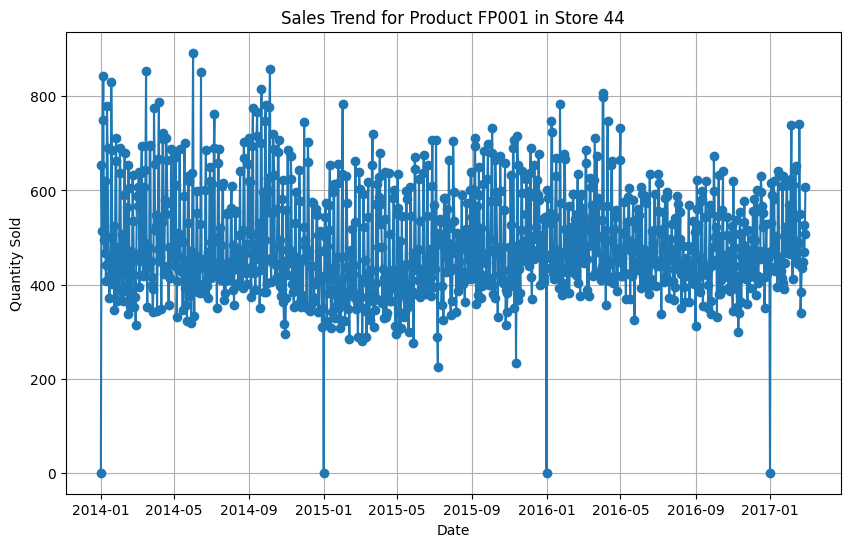

In [74]:
# Prepared FP001

FP001 = merged_data[(merged_data['Store_ID'] == 44) & (merged_data['Product_Code'] == 'FP001')]

plt.figure(figsize=(10, 6))
plt.plot(FP001['Date'], FP001['Qty'], marker='o', linestyle='-')
plt.title('Sales Trend for Product FP001 in Store 44')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()

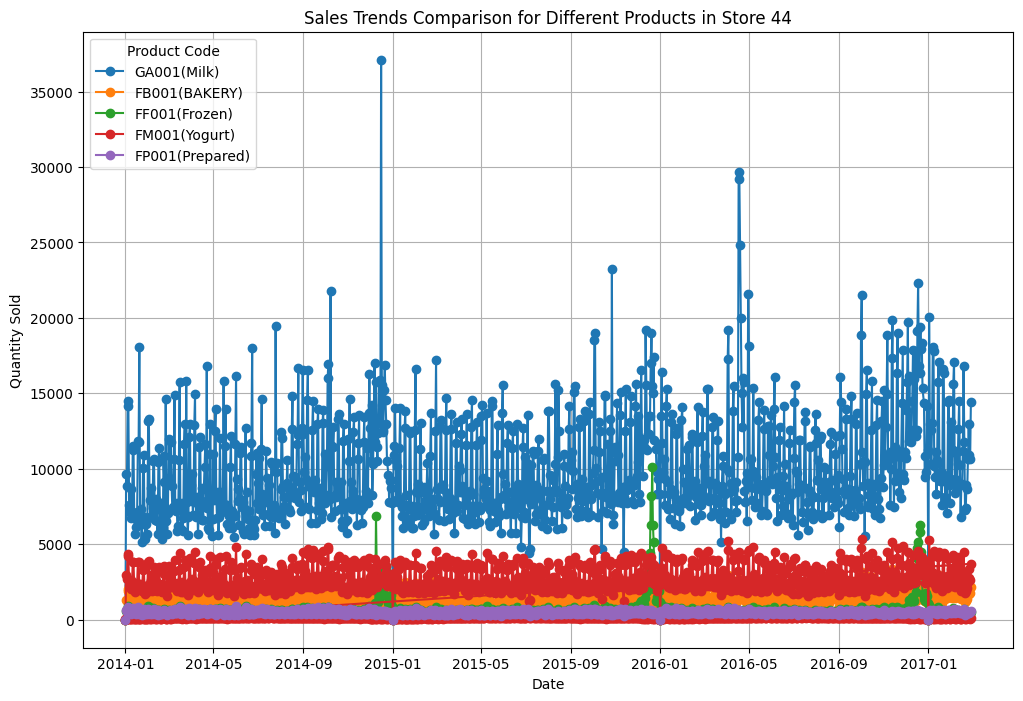

In [76]:
plt.figure(figsize=(12, 8))

# Milk GA001
plt.plot(GA001['Date'], GA001['Qty'], marker='o', linestyle='-', label='GA001(Milk)')

# BAKERY FB001
plt.plot(FB001['Date'], FB001['Qty'], marker='o', linestyle='-', label='FB001(BAKERY)')

# Frozen FF001
plt.plot(FF001['Date'], FF001['Qty'], marker='o', linestyle='-', label='FF001(Frozen)')

# Yogurt FM001
plt.plot(FM001['Date'], FM001['Qty'], marker='o', linestyle='-', label='FM001(Yogurt)')

# Prepared FP001
plt.plot(FP001['Date'], FP001['Qty'], marker='o', linestyle='-', label='FP001(Prepared)')

plt.title('Sales Trends Comparison for Different Products in Store 44')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend(title='Product Code', loc='upper left')
plt.grid(True)
plt.show()


<h2>42번 상품</h2>

In [104]:
same_category_42 = merged_data[(merged_data['Store_ID'] == 44) & (merged_data['Product_Code'] == 'FM001') & (merged_data['SubCategory'] == 'Agricultural products')]

In [105]:
same_category_42

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
933120,2014-01-01,44,51.0,42,FM001,Agricultural products,Grocery,2,5
933121,2014-01-02,44,76.0,42,FM001,Agricultural products,Grocery,2,5
933122,2014-01-03,44,74.0,42,FM001,Agricultural products,Grocery,2,5
933123,2014-01-04,44,78.0,42,FM001,Agricultural products,Grocery,2,5
933124,2014-01-05,44,88.0,42,FM001,Agricultural products,Grocery,2,5
...,...,...,...,...,...,...,...,...,...
934270,2017-02-24,44,91.0,42,FM001,Agricultural products,Grocery,2,5
934271,2017-02-25,44,105.0,42,FM001,Agricultural products,Grocery,2,5
934272,2017-02-26,44,108.0,42,FM001,Agricultural products,Grocery,2,5
934273,2017-02-27,44,78.0,42,FM001,Agricultural products,Grocery,2,5


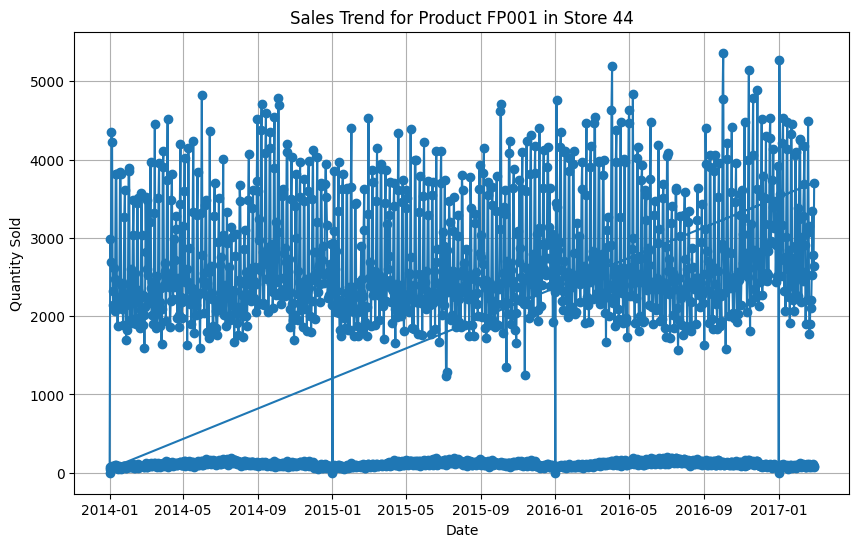

In [110]:
FM001 = merged_data[(merged_data['Store_ID'] == 44) & (merged_data['Product_Code'] == 'FM001')]

plt.figure(figsize=(10, 6))
plt.plot(FM001['Date'], FM001['Qty'], marker='o', linestyle='-')
plt.title('Sales Trend for Product FP001 in Store 44')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()

### 3) 휘발류 가격과 상품 판매량 추이 비교

In [113]:
oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')

In [116]:
oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='bfill')

In [118]:
oil_merged_data = pd.merge(oil_price, merged_data, on='Date')

In [119]:
oil_merged_data

,Date,WTI_Price,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,2014-01-01,95.14,1,0.000,3,DB001,Beverage,Drink,2,8
1,2014-01-01,95.14,2,0.000,3,DB001,Beverage,Drink,2,8
2,2014-01-01,95.14,3,0.000,3,DB001,Beverage,Drink,2,8
3,2014-01-01,95.14,4,0.000,3,DB001,Beverage,Drink,2,8
4,2014-01-01,95.14,5,0.000,3,DB001,Beverage,Drink,2,8
...,...,...,...,...,...,...,...,...,...,...
667450,2017-02-28,54.00,51,41.852,32,GS001,Seafood,Grocery,3,34
667451,2017-02-28,54.00,52,0.000,32,GS001,Seafood,Grocery,3,34
667452,2017-02-28,54.00,53,5.000,32,GS001,Seafood,Grocery,3,34
667453,2017-02-28,54.00,54,4.000,32,GS001,Seafood,Grocery,3,34


In [124]:
oil_merged_data_44 = oil_merged_data[(oil_merged_data['Store_ID'] == 44)]

In [125]:
oil_merged_data_44

,Date,WTI_Price,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
43,2014-01-01,95.14,44,0.000,3,DB001,Beverage,Drink,2,8
97,2014-01-01,95.14,44,0.000,5,FB001,BAKERY,Food,2,6
151,2014-01-01,95.14,44,0.000,7,HC001,Cleaning,Household Goods,2,15
205,2014-01-01,95.14,44,0.000,8,FM001,Yogurt,Food,2,4
259,2014-01-01,95.14,44,0.000,10,GE001,EGGS,Grocery,2,5
...,...,...,...,...,...,...,...,...,...,...
667281,2017-02-28,54.00,44,1057.687,24,GM001,Meats,Grocery,3,17
667335,2017-02-28,54.00,44,79.000,27,HH001,Home Appliances,Household Goods,2,150
667389,2017-02-28,54.00,44,607.427,29,FP001,Prepared,Food,2,18
667443,2017-02-28,54.00,44,157.066,32,GS001,Seafood,Grocery,3,34


In [135]:
oil_merged_data_44_subset = oil_merged_data_44[['Date', 'Qty']]

daily_qty_sum_44 = oil_merged_data_44_subset.groupby('Date')['Qty'].sum().reset_index()

print(daily_qty_sum_44)

          Date           Qty
0   2014-01-01     51.000000
1   2014-01-02  30612.172000
2   2014-01-03  28289.686000
3   2014-01-06  23884.642970
4   2014-01-07  22294.932000
..         ...           ...
820 2017-02-22  25086.034000
821 2017-02-23  25147.003996
822 2017-02-24  31455.323000
823 2017-02-27  31251.382000
824 2017-02-28  42509.292000

[825 rows x 2 columns]


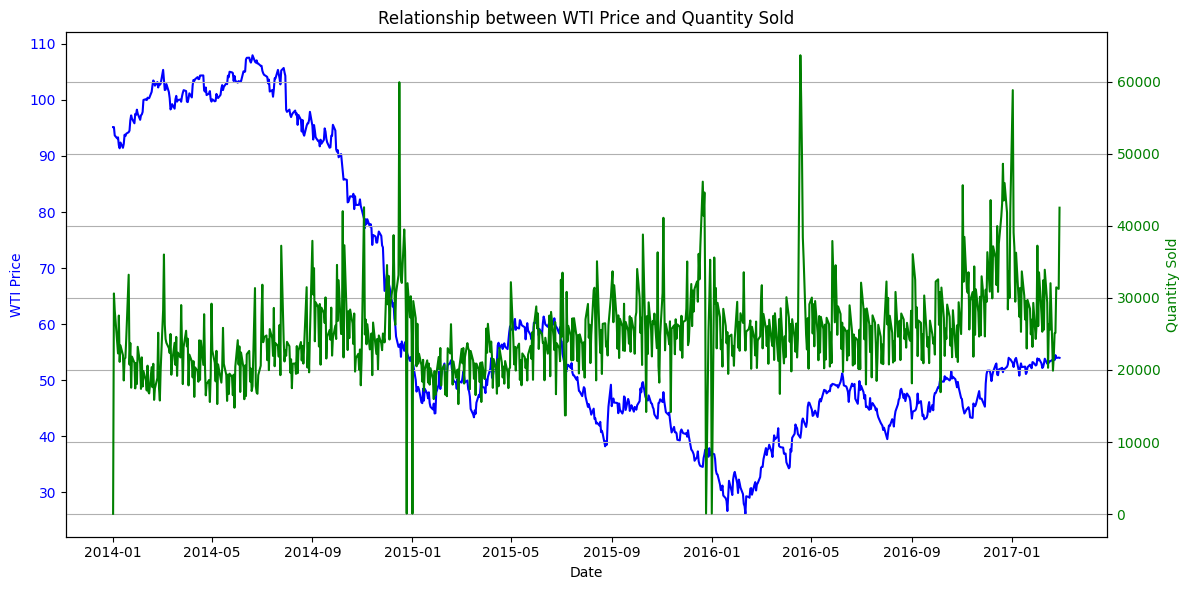

상관관계: -0.24316879234321337


In [150]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(oil_price['Date'], oil_price['WTI_Price'], label='WTI Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('WTI Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(daily_qty_sum_44['Date'], daily_qty_sum_44['Qty'], label='Quantity Sold', color='green')
ax2.set_ylabel('Quantity Sold', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Relationship between WTI Price and Quantity Sold')
fig.tight_layout()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

correlation = oil_price['WTI_Price'].corr(daily_qty_sum_44['Qty'])
print("상관관계:", correlation)

### 4) 방문 고객수와 상품 판매량 추이 비교

In [143]:
count_qty = pd.merge(daily_qty_sum_44, orders, on='Date')

In [146]:
count_qty_44 = count_qty[(count_qty['Store_ID'] == 44)]

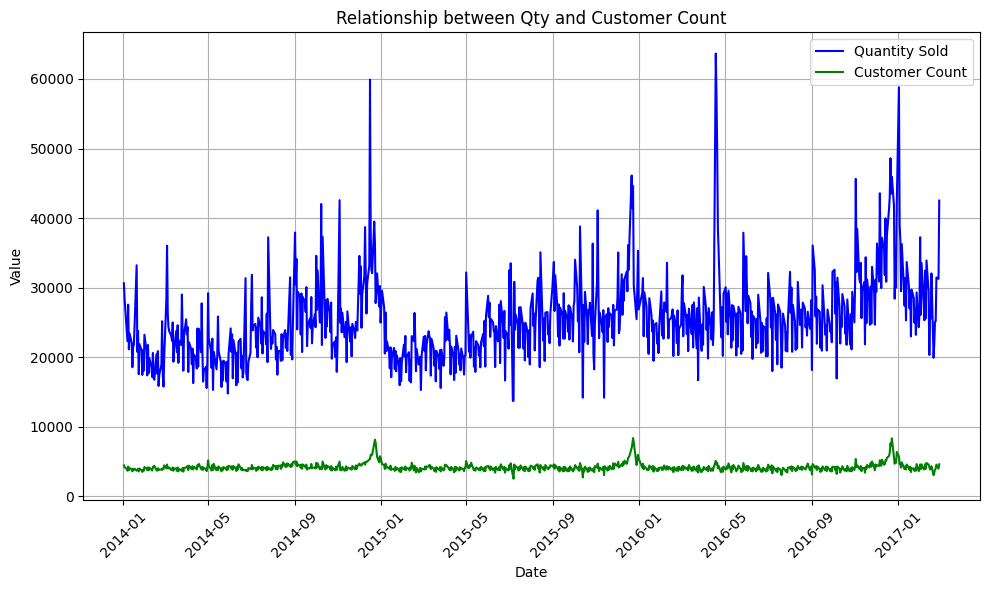

상관관계: 0.6698874743950217


In [152]:
plt.figure(figsize=(10, 6))

plt.plot(count_qty_44['Date'], count_qty_44['Qty'], label='Quantity Sold', color='blue')
plt.plot(count_qty_44['Date'], count_qty_44['CustomerCount'], label='Customer Count', color='green')

plt.title('Relationship between Qty and Customer Count')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

correlation = count_qty_44['Qty'].corr(count_qty_44['CustomerCount'])
print("상관관계:", correlation)

## **(2) 시계열 패턴 찾아보기2**

* 변화량과 비교해보기

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [153]:
count_qty_44

,Date,Qty,Store_ID,CustomerCount
39,2014-01-02,30612.172000,44,4422
86,2014-01-03,28289.686000,44,4167
133,2014-01-06,23884.642970,44,3917
180,2014-01-07,22294.932000,44,3663
227,2014-01-08,27549.842000,44,4254
...,...,...,...,...
40923,2017-02-22,25086.034000,44,3834
40976,2017-02-23,25147.003996,44,3955
41029,2017-02-24,31455.323000,44,4549
41082,2017-02-27,31251.382000,44,3961


In [157]:
target = merged_data[(merged_data['Store_ID'] == 44) & (merged_data['Product_Code'].isin(['FM001', 'GA001', 'DB001']))]

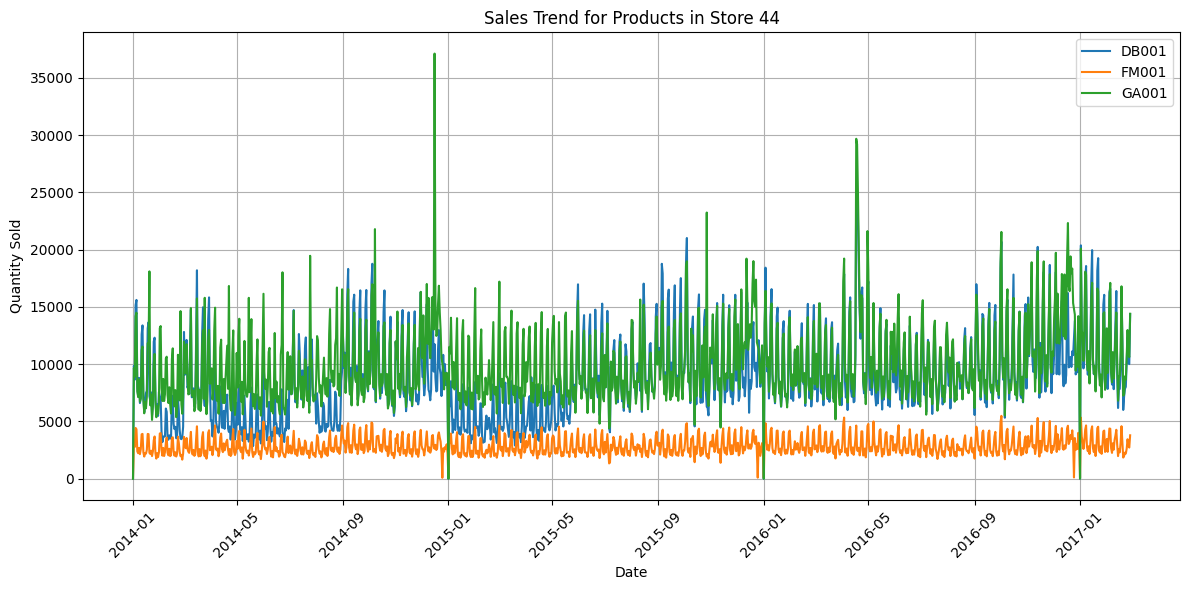

In [160]:
product_code_qty_sum = target.groupby(['Date', 'Product_Code'])['Qty'].sum().reset_index()

product_codes = product_code_qty_sum['Product_Code'].unique()

plt.figure(figsize=(12, 6))

for product_code in product_codes:
    data = product_code_qty_sum[product_code_qty_sum['Product_Code'] == product_code]
    plt.plot(data['Date'], data['Qty'], label=product_code)

plt.title('Sales Trend for Products in Store 44')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2) 요일별 변화량 비교

In [162]:
product_code_qty_sum['Date'] = pd.to_datetime(product_code_qty_sum['Date'])
product_code_qty_sum['Day_of_week'] = product_code_qty_sum['Date'].dt.day_name()

avg_qty_by_day = product_code_qty_sum.groupby(['Product_Code', 'Day_of_week'])['Qty'].mean().reset_index()

for product_code in product_codes:
    print(f"Product Code: {product_code}")
    product_data = avg_qty_by_day[avg_qty_by_day['Product_Code'] == product_code]
    for index, row in product_data.iterrows():
        print(f"Day: {row['Day_of_week']}, Average Qty: {row['Qty']:.2f}")
    print()

Product Code: DB001
Day: Friday, Average Qty: 7628.46
Day: Monday, Average Qty: 7802.48
Day: Saturday, Average Qty: 11864.36
Day: Sunday, Average Qty: 12772.81
Day: Thursday, Average Qty: 6276.74
Day: Tuesday, Average Qty: 7070.33
Day: Wednesday, Average Qty: 7653.99

Product Code: FM001
Day: Friday, Average Qty: 2636.68
Day: Monday, Average Qty: 2538.70
Day: Saturday, Average Qty: 3742.32
Day: Sunday, Average Qty: 3935.84
Day: Thursday, Average Qty: 2099.16
Day: Tuesday, Average Qty: 2315.90
Day: Wednesday, Average Qty: 2643.16

Product Code: GA001
Day: Friday, Average Qty: 8889.49
Day: Monday, Average Qty: 9267.00
Day: Saturday, Average Qty: 12842.54
Day: Sunday, Average Qty: 13709.82
Day: Thursday, Average Qty: 7384.05
Day: Tuesday, Average Qty: 8664.38
Day: Wednesday, Average Qty: 9292.94



### 3) 시계열 데이터 분해

In [184]:
def decomp_plot(Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

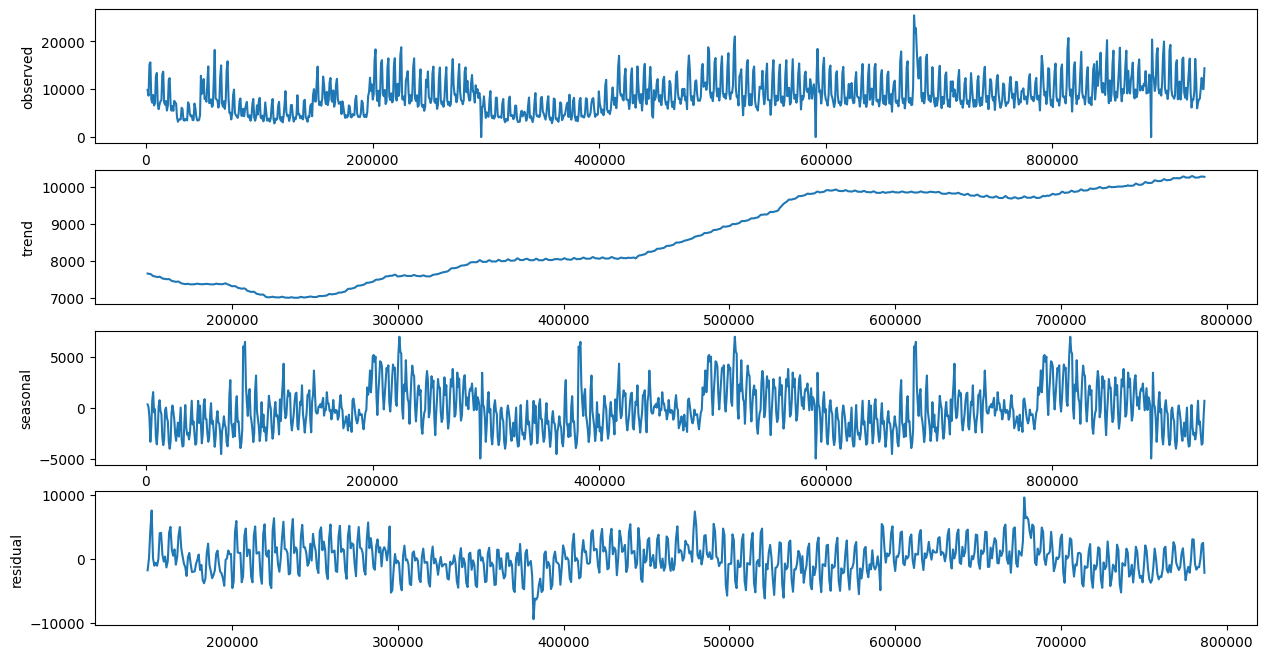

,observed,trend,seasonal,residual
1456,9853.0,NaN,365.312451,NaN
2267,8647.0,NaN,106.450808,NaN
3078,15153.0,NaN,-968.498508,NaN
3889,15606.0,NaN,-3302.316316,NaN
4700,7900.0,NaN,-1755.727275,NaN
...,...,...,...,...
930865,10208.0,NaN,-2535.210836,NaN
931676,12361.0,NaN,-3584.549192,NaN
932487,10108.0,NaN,-3438.957412,NaN
933298,10006.0,NaN,-1010.798508,NaN


In [200]:
# DB001

decomp_plot(3, '2014-01-02', '2017-02-28', 365)

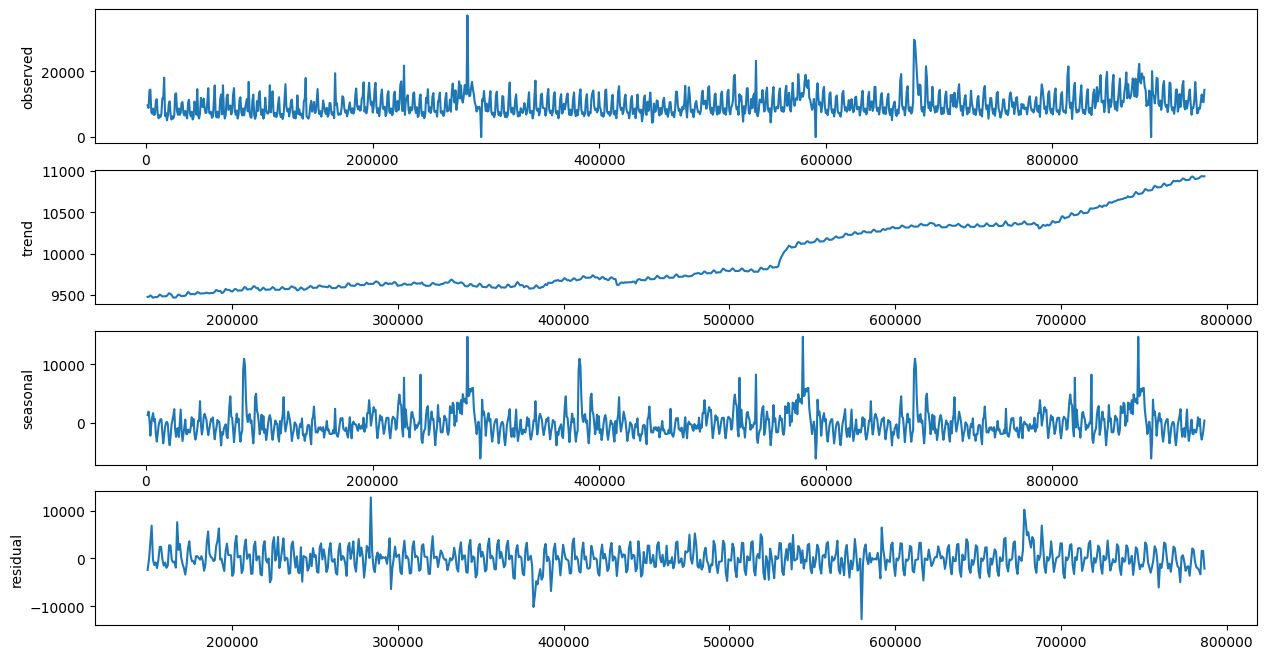

,observed,trend,seasonal,residual
1462,9647.0,NaN,1323.588066,NaN
2273,8879.0,NaN,1922.848340,NaN
3084,14188.0,NaN,551.036011,NaN
3895,14490.0,NaN,-2212.054400,NaN
4706,7614.0,NaN,-236.402345,NaN
...,...,...,...,...
930871,10630.0,NaN,-1949.083167,NaN
931682,12978.0,NaN,-2877.537962,NaN
932493,10899.0,NaN,-2195.809195,NaN
933304,10618.0,NaN,-1072.210565,NaN


In [198]:
# GA001

decomp_plot(12, '2014-01-02', '2017-02-28', 365)

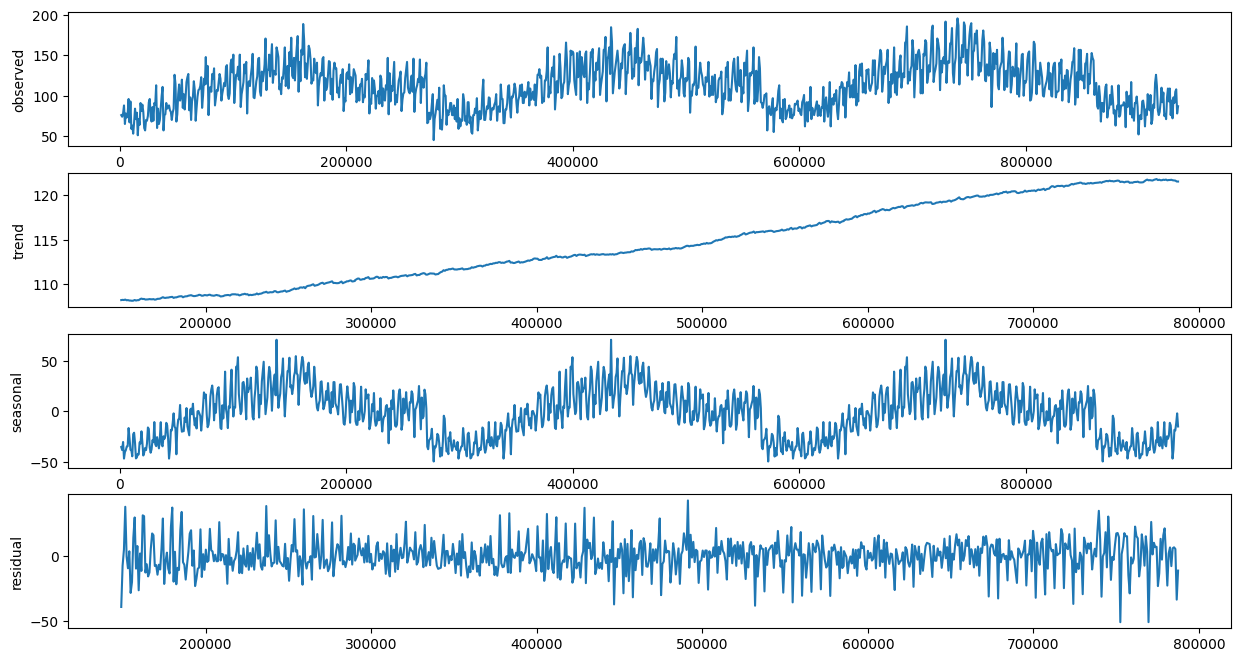

,observed,trend,seasonal,residual
1469,76.0,NaN,-35.235002,NaN
2280,74.0,NaN,-38.280208,NaN
3091,78.0,NaN,-30.248701,NaN
3902,88.0,NaN,-46.714454,NaN
4713,65.0,NaN,-40.236372,NaN
...,...,...,...,...
930878,91.0,NaN,-18.250071,NaN
931689,105.0,NaN,-18.807605,NaN
932500,108.0,NaN,-11.358290,NaN
933311,78.0,NaN,-1.896646,NaN


In [197]:
# FM001

decomp_plot(42, '2014-01-02', '2017-02-28', 365)

### 4) 그 외 패턴 찾아보기

In [ ]:
# README 파일 참고

# **3.패턴 정리하기**

* 다양한 탐색을 통해 찾은 시계열 패턴을 적어 봅시다.

In [ ]:
# README 파일 참고